In [1]:
import torch
import torch.nn.functional as F
from torch import nn
from torch.nn import BatchNorm1d, ReLU, Linear, Sequential
import numpy as np
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, global_mean_pool, GATConv, GINConv, global_add_pool
import os
from torch.utils.data import DataLoader
from torch_geometric.data import InMemoryDataset, download_url
import networkx as nx
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

In [2]:
def train(epoch):
    model.train()
    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.batch)
        loss = F.nll_loss(output, data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_dataset)


def test(loader):
    model.eval()

    correct = 0
    for data in loader:
        data = data.to(device)
        output = model(data.x, data.edge_index, data.batch)
        pred = output.max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)

In [3]:
def distance(pt1, pt2):
    coord1 = pt1[:-1]
    coord2 = pt2[:-1]
    output = ((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2 + (coord1[2] - coord2[2])**2)**(1/2)
    return output

In [4]:
def read_xyz():
    with open("ethene_ts.xyz") as f:
        E = []
        R = []
        while True:
            line = f.readline().split()

            if len(line) == 2:
                E.append(float(line[-2]))

            elif len(line) > 2:
                R.append([float(val) for val in line[1:4]] + [float(line[0] == 'C')])

            elif len(line) == 0:
                break
    
    
    data_lst = []
    for j in range(0, len(R), 6):
        idx = 0
        edges = []
        edges.append([idx, idx+1])
        edges.append([idx, idx+2])
        edges.append([idx, idx+3])
        edges.append([idx+3, idx+4])
        edges.append([idx+3, idx+5])
        edges.append([idx+1, idx])
        edges.append([idx+2, idx])
        edges.append([idx+3, idx])
        edges.append([idx+4, idx+3])
        edges.append([idx+5, idx+3])
        edge_index = np.array(edges).T
        x = torch.tensor(R[j:j+6], dtype=torch.float)
        y = torch.tensor(E[int(j/6)], dtype=torch.float)
        weights = []
        weights.append(distance(R[j], R[j+1]))
        weights.append(distance(R[j], R[j+2]))
        weights.append(distance(R[j], R[j+3]))
        weights.append(distance(R[j+3], R[j+4]))
        weights.append(distance(R[j+3], R[j+5]))
        weights.append(distance(R[j], R[j+1]))
        weights.append(distance(R[j], R[j+2]))
        weights.append(distance(R[j], R[j+3]))
        weights.append(distance(R[j+3], R[j+4]))
        weights.append(distance(R[j+3], R[j+5]))
        data = Data(x=x, y=y, edge_index=torch.tensor(edge_index, dtype=torch.long), edge_weight=torch.tensor(weights, dtype=torch.float))
        data_lst.append(data)
    return data_lst

In [5]:
class Xyz(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return ['ethene_ts.xyz']

    @property
    def processed_file_names(self):
        return ['ethene_ts.pt']

    def download(self):
        pass

    def process(self):
        # Read data into huge `Data` list.
        data_list = read_xyz()

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
class netlist(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return ['netlist.gpickle']

    @property
    def processed_file_names(self):
        return ['netlist.pt']

    def download(self):
        pass

    def process(self):
        # Read data into huge `Data` list.
        data_list = []

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]
            
        paths = np.load("/home/zluo/new_chip_design/paths.npy")
        
        path_lst = []
        for f in paths:
            path_lst.append(f.split("_")[:-1])

        path_lst = np.array([lst[1] for lst in path_lst]).reshape(-1, 1)
        encoder = OneHotEncoder()
        labels = encoder.fit_transform(path_lst).toarray()
        labels = torch.tensor(labels, dtype=torch.float)
        
        X_eig = np.load("/home/zluo/new_chip_design/eig_all.npy")
        X_new = np.load("/home/zluo/new_chip_design/new_X.npy")
        
        X_eig = StandardScaler().fit_transform(X_eig)
        X_new = StandardScaler().fit_transform(X_new)
        
        for index in range(len(paths)):
            path = paths[index]
            netlist_name = path.split(".")[0]
            g_path = f"/home/zluo/new_chip_design/gps/{netlist_name}.gpickle"
            graph = nx.read_gpickle(g_path)
            nodelist = list(graph.nodes())
            nodedict = {nodelist[idx]:idx for idx in range(len(nodelist))}
            X = torch.tensor([[graph.in_degree()[node], graph.out_degree()[node]] for node in nodelist], dtype=torch.float)
            y = labels[index]
            edge_index = torch.tensor([[nodedict[tp[0]], nodedict[tp[1]]] for tp in list(graph.edges())], dtype=torch.long).T
            gp_data = Data(x=X, y=y, edge_index=edge_index, eig=torch.tensor(X_eig[index], dtype=torch.float), stats=torch.tensor(X_new[index], dtype=torch.float))

            data_list.append(gp_data)
            
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [8]:
import torch_geometric.transforms as T
from torch_geometric.datasets import OGB_MAG
from torch_geometric.nn import HeteroConv, GCNConv, SAGEConv, GATConv, Linear


dataset = OGB_MAG(root='./data', preprocess='metapath2vec', transform=T.ToUndirected())
data = dataset[0]

In [12]:
data['author', 'writes', 'paper'].edge_index 

tensor([[      0,       0,       0,  ..., 1134647, 1134648, 1134648],
        [  19703,  289285,  311768,  ...,  657395,  671118,  719594]])

In [13]:
data

HeteroData(
  paper={
    x=[736389, 128],
    year=[736389],
    y=[736389],
    train_mask=[736389],
    val_mask=[736389],
    test_mask=[736389]
  },
  author={ x=[1134649, 128] },
  institution={ x=[8740, 128] },
  field_of_study={ x=[59965, 128] },
  (author, affiliated_with, institution)={},
  (author, affiliated_with, institution)={ edge_index=[2, 1043998] },
  (author, writes, paper)={ edge_index=[2, 7145660] },
  (paper, cites, paper)={ edge_index=[2, 10792672] },
  (paper, has_topic, field_of_study)={ edge_index=[2, 7505078] },
  (institution, rev_affiliated_with, author)={ edge_index=[2, 1043998] },
  (paper, rev_writes, author)={ edge_index=[2, 7145660] },
  (field_of_study, rev_has_topic, paper)={ edge_index=[2, 7505078] }
)

data, val_dict = torch.load("/home/zluo/nn/lrgb/datasets/peptides-functional/processed/geometric_data_processed.pt")

In [331]:
dataset = netlist("/home/zluo/nn/gnn/")
#dataset.process()

In [115]:
data

Data(edge_index=[2, 4773974], edge_attr=[4773974, 3], x=[2344859, 9], y=[15535, 10])

In [129]:
all_edgs = data.edge_index[0][:1000000]
all_edgs_target = data.edge_index[1][:1000000]
all_edgs_attr = data.edge_attr[:1000000]
all_real_edgs_T = data.edge_index.T[:1000000]

In [130]:
val

tensor(254)

In [131]:
to_split = []
Edges = []
Edges_attr = []
pre_val = -1
pre_edge_idx = 0
pre_max = 0
for edge_idx in range(len(all_edgs)):
    val = all_edgs[edge_idx]
    if val > pre_max:
        pre_max = val
    
    if val == 0 and edge_idx != 0:
        to_split.append(pre_max)
        pre_max = 0
        Edges.append(all_real_edgs_T[pre_edge_idx:edge_idx].T)
        Edges_attr.append(all_edgs_attr[pre_edge_idx:edge_idx])
        pre_edge_idx = edge_idx
        
    pre_val = val

In [132]:
data_lst = []
X = []
Y = []
curr_pos = 0
i = 0
for split_idx in to_split:
    X.append(data.x[curr_pos:curr_pos + split_idx + 1])
    Y.append(data.y[i])
    curr_pos = curr_pos + split_idx + 1
    i += 1

In [133]:
for idx in range(len(X)):
    data_lst.append(Data(x=X[idx], edge_index=Edges[idx], edge_attr=Edges_attr[idx], y=Y[idx]))

In [142]:
data = data_lst[0]
data

Data(x=[119, 9], edge_index=[2, 244], edge_attr=[244, 3], y=[10])

In [192]:
data_revised_lst = []
for data in data_lst:
    edgs = data.edge_index.T.tolist()
    to_add = []
    for i in range(len(edgs)):
        to_add.append(np.random.choice(len(data.x), 2))
    data_revised = Data(x=data.x, edge_index=torch.LongTensor(np.concatenate([edgs, to_add]).T), y=data.y)
    data_revised_lst.append(data_revised)
    print(len(data_revised_lst), len(data_lst))

1 3247
2 3247
3 3247
4 3247
5 3247
6 3247
7 3247
8 3247
9 3247
10 3247
11 3247
12 3247
13 3247
14 3247
15 3247
16 3247
17 3247
18 3247
19 3247
20 3247
21 3247
22 3247
23 3247
24 3247
25 3247
26 3247
27 3247
28 3247
29 3247
30 3247
31 3247
32 3247
33 3247
34 3247
35 3247
36 3247
37 3247
38 3247
39 3247
40 3247
41 3247
42 3247
43 3247
44 3247
45 3247
46 3247
47 3247
48 3247
49 3247
50 3247
51 3247
52 3247
53 3247
54 3247
55 3247
56 3247
57 3247
58 3247
59 3247
60 3247
61 3247
62 3247
63 3247
64 3247
65 3247
66 3247
67 3247
68 3247
69 3247
70 3247
71 3247
72 3247
73 3247
74 3247
75 3247
76 3247
77 3247
78 3247
79 3247
80 3247
81 3247
82 3247
83 3247
84 3247
85 3247
86 3247
87 3247
88 3247
89 3247
90 3247
91 3247
92 3247
93 3247
94 3247
95 3247
96 3247
97 3247
98 3247
99 3247
100 3247
101 3247
102 3247
103 3247
104 3247
105 3247
106 3247
107 3247
108 3247
109 3247
110 3247
111 3247
112 3247
113 3247
114 3247
115 3247
116 3247
117 3247
118 3247
119 3247
120 3247
121 3247
122 3247
123 3247
1

950 3247
951 3247
952 3247
953 3247
954 3247
955 3247
956 3247
957 3247
958 3247
959 3247
960 3247
961 3247
962 3247
963 3247
964 3247
965 3247
966 3247
967 3247
968 3247
969 3247
970 3247
971 3247
972 3247
973 3247
974 3247
975 3247
976 3247
977 3247
978 3247
979 3247
980 3247
981 3247
982 3247
983 3247
984 3247
985 3247
986 3247
987 3247
988 3247
989 3247
990 3247
991 3247
992 3247
993 3247
994 3247
995 3247
996 3247
997 3247
998 3247
999 3247
1000 3247
1001 3247
1002 3247
1003 3247
1004 3247
1005 3247
1006 3247
1007 3247
1008 3247
1009 3247
1010 3247
1011 3247
1012 3247
1013 3247
1014 3247
1015 3247
1016 3247
1017 3247
1018 3247
1019 3247
1020 3247
1021 3247
1022 3247
1023 3247
1024 3247
1025 3247
1026 3247
1027 3247
1028 3247
1029 3247
1030 3247
1031 3247
1032 3247
1033 3247
1034 3247
1035 3247
1036 3247
1037 3247
1038 3247
1039 3247
1040 3247
1041 3247
1042 3247
1043 3247
1044 3247
1045 3247
1046 3247
1047 3247
1048 3247
1049 3247
1050 3247
1051 3247
1052 3247
1053 3247
1054 3247


1803 3247
1804 3247
1805 3247
1806 3247
1807 3247
1808 3247
1809 3247
1810 3247
1811 3247
1812 3247
1813 3247
1814 3247
1815 3247
1816 3247
1817 3247
1818 3247
1819 3247
1820 3247
1821 3247
1822 3247
1823 3247
1824 3247
1825 3247
1826 3247
1827 3247
1828 3247
1829 3247
1830 3247
1831 3247
1832 3247
1833 3247
1834 3247
1835 3247
1836 3247
1837 3247
1838 3247
1839 3247
1840 3247
1841 3247
1842 3247
1843 3247
1844 3247
1845 3247
1846 3247
1847 3247
1848 3247
1849 3247
1850 3247
1851 3247
1852 3247
1853 3247
1854 3247
1855 3247
1856 3247
1857 3247
1858 3247
1859 3247
1860 3247
1861 3247
1862 3247
1863 3247
1864 3247
1865 3247
1866 3247
1867 3247
1868 3247
1869 3247
1870 3247
1871 3247
1872 3247
1873 3247
1874 3247
1875 3247
1876 3247
1877 3247
1878 3247
1879 3247
1880 3247
1881 3247
1882 3247
1883 3247
1884 3247
1885 3247
1886 3247
1887 3247
1888 3247
1889 3247
1890 3247
1891 3247
1892 3247
1893 3247
1894 3247
1895 3247
1896 3247
1897 3247
1898 3247
1899 3247
1900 3247
1901 3247
1902 3247


2629 3247
2630 3247
2631 3247
2632 3247
2633 3247
2634 3247
2635 3247
2636 3247
2637 3247
2638 3247
2639 3247
2640 3247
2641 3247
2642 3247
2643 3247
2644 3247
2645 3247
2646 3247
2647 3247
2648 3247
2649 3247
2650 3247
2651 3247
2652 3247
2653 3247
2654 3247
2655 3247
2656 3247
2657 3247
2658 3247
2659 3247
2660 3247
2661 3247
2662 3247
2663 3247
2664 3247
2665 3247
2666 3247
2667 3247
2668 3247
2669 3247
2670 3247
2671 3247
2672 3247
2673 3247
2674 3247
2675 3247
2676 3247
2677 3247
2678 3247
2679 3247
2680 3247
2681 3247
2682 3247
2683 3247
2684 3247
2685 3247
2686 3247
2687 3247
2688 3247
2689 3247
2690 3247
2691 3247
2692 3247
2693 3247
2694 3247
2695 3247
2696 3247
2697 3247
2698 3247
2699 3247
2700 3247
2701 3247
2702 3247
2703 3247
2704 3247
2705 3247
2706 3247
2707 3247
2708 3247
2709 3247
2710 3247
2711 3247
2712 3247
2713 3247
2714 3247
2715 3247
2716 3247
2717 3247
2718 3247
2719 3247
2720 3247
2721 3247
2722 3247
2723 3247
2724 3247
2725 3247
2726 3247
2727 3247
2728 3247


In [193]:
data_lst

[Data(x=[119, 9], edge_index=[2, 244], edge_attr=[244, 3], y=[10]),
 Data(x=[338, 9], edge_index=[2, 682], edge_attr=[682, 3], y=[10]),
 Data(x=[209, 9], edge_index=[2, 418], edge_attr=[418, 3], y=[10]),
 Data(x=[220, 9], edge_index=[2, 446], edge_attr=[446, 3], y=[10]),
 Data(x=[155, 9], edge_index=[2, 324], edge_attr=[324, 3], y=[10]),
 Data(x=[46, 9], edge_index=[2, 94], edge_attr=[94, 3], y=[10]),
 Data(x=[228, 9], edge_index=[2, 456], edge_attr=[456, 3], y=[10]),
 Data(x=[126, 9], edge_index=[2, 254], edge_attr=[254, 3], y=[10]),
 Data(x=[99, 9], edge_index=[2, 200], edge_attr=[200, 3], y=[10]),
 Data(x=[290, 9], edge_index=[2, 592], edge_attr=[592, 3], y=[10]),
 Data(x=[120, 9], edge_index=[2, 244], edge_attr=[244, 3], y=[10]),
 Data(x=[145, 9], edge_index=[2, 298], edge_attr=[298, 3], y=[10]),
 Data(x=[71, 9], edge_index=[2, 152], edge_attr=[152, 3], y=[10]),
 Data(x=[178, 9], edge_index=[2, 364], edge_attr=[364, 3], y=[10]),
 Data(x=[205, 9], edge_index=[2, 410], edge_attr=[410

In [195]:
data_revised_lst[0].edge_index

tensor([[  0,   1,   1,   2,   1,   3,   3,   4,   4,   5,   5,   6,   6,   7,
           6,   8,   8,   9,   9,  10,  10,  11,  11,  12,  12,  13,   8,  14,
          14,  15,  15,  16,  15,  17,  17,  18,  17,  19,  19,  20,  19,  21,
           4,  22,  22,  23,  22,  24,  24,  25,  25,  26,  26,  27,  27,  28,
          28,  29,  29,  30,  25,  31,  31,  32,  31,  33,  33,  34,  34,  35,
          35,  36,  35,  37,  37,  38,  38,  39,  39,  40,  40,  41,  41,  42,
          42,  43,  43,  44,  43,  45,  45,  46,  38,  47,  47,  48,  47,  49,
          49,  50,  50,  51,  51,  52,  52,  53,  53,  54,  54,  55,  54,  56,
          56,  57,  57,  58,  58,  59,  59,  60,  59,  61,  57,  62,  62,  63,
          62,  64,  64,  65,  65,  66,  66,  67,  67,  68,  68,  69,  69,  70,
          65,  71,  71,  72,  71,  73,  73,  74,  74,  75,  75,  76,  75,  77,
          77,  78,  78,  79,  79,  80,  80,  81,  81,  82,  82,  83,  78,  84,
          84,  85,  84,  86,  86,  87,  87,  88,  88

In [196]:
class GCN(torch.nn.Module):
    def __init__(self, input_channels, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(input_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.conv5 = GCNConv(hidden_channels, hidden_channels)
        self.fc1 = nn.Linear(hidden_channels, 30)
        self.fc2 = nn.Linear(30, 10)

    def forward(self, x, edge_index, batch):
        #x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        #x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.elu(x)
        #x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv3(x, edge_index)

        x = global_add_pool(x, batch)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)

In [200]:
model = GCN(9, 16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [198]:
for epoch in range(100):
    model.train()

    loss_train = 0
    for data in data_revised_lst:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x.type(torch.FloatTensor), data.edge_index, data.batch)
        loss = F.cross_entropy(output[0], data.y)
        loss.backward()
        loss_train += loss.item()
        optimizer.step()
    
    loss_train = loss_train/len(data_lst)
    print(f"{loss_train}")

3.829431796699423
3.223306044142247
3.1812168497249167
3.1593088492966817
3.1417884419505544
3.139465474755646
3.138994383947791
3.138874214283679
3.1388396797710323
3.138829326974747
3.138826297399335
3.138825558756989
3.138825476224657
3.1388255610148796
3.138825671669884
3.1388257469696232
3.138825805656426
3.1388258435449345


KeyboardInterrupt: 

In [201]:
for epoch in range(100):
    model.train()

    loss_train = 0
    for data in data_lst:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x.type(torch.FloatTensor), data.edge_index, data.batch)
        loss = F.cross_entropy(output[0], data.y)
        loss.backward()
        loss_train += loss.item()
        optimizer.step()
    
    loss_train = loss_train/len(data_lst)
    print(f"{loss_train}")

3.7502220971093916
3.22209234513207
3.17681632981434
3.156442372219578
3.148716520117656
3.139383730776023
3.138975618177096
3.1388691165353984
3.1388381489578085
3.138828833065732
3.1388261433304145
3.1388255059443733
3.1388254582533146
3.1388255485505883
3.138825664786071


KeyboardInterrupt: 

In [ ]:
from torch_geometric.transforms import RandomLinkSplit

transform = RandomLinkSplit(is_undirected=True)
train_data, val_data, test_data = transform(data)

In [10]:
# ran_idx = np.random.choice([idx for idx in range(len(dataset))], size=2000, replace=True)
# train_idx = ran_idx[:int(len(ran_idx)*0.8)]
# test_idx = ran_idx[int(len(ran_idx)*0.8):]

train_idx, test_idx = np.load("/home/zluo/new_chip_design/idx_lst.npy", allow_pickle=True)

In [11]:
train_dataset = dataset[train_idx]
test_dataset = dataset[test_idx]

In [228]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.fc1 = nn.Linear(hidden_channels+10, 20)
        self.fc2 = nn.Linear(20, 5)
        self.fc3 = nn.Linear(hidden_channels, 5)

    def forward(self, x, edge_index, batch, eig, stats):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        
        x = global_mean_pool(x, batch)
        
        x = torch.cat((x, stats.reshape(x.shape[0], 10)), dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)

In [12]:
class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.hid = 8
        self.in_head = 8
        self.out_head = 1
        
        self.conv1 = GATConv(dataset.num_features, self.hid, heads=self.in_head, dropout=0.6)
        self.conv2 = GATConv(self.hid*self.in_head, self.hid, concat=False,
                             heads=self.out_head, dropout=0.6)
        
        self.fc1 = nn.Linear(self.hid+10, 20)
        self.fc2 = nn.Linear(20, 5)

    def forward(self, x, edge_index, batch, eig, stats):
        
        # Dropout before the GAT layer is used to avoid overfitting in small datasets like Cora.
        # One can skip them if the dataset is sufficiently large.
        
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        
        x = global_mean_pool(x, batch)
        
        x = torch.cat((x, stats.reshape(x.shape[0], 10)), dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)

In [13]:
class GIN(torch.nn.Module):
    """GIN"""
    def __init__(self, dim_h):
        super(GIN, self).__init__()
        self.conv1 = GINConv(
            Sequential(Linear(dataset.num_node_features, dim_h),
                       BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()), dropout=0.6)
        self.conv2 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()), dropout=0.6)

        self.lin1 = Linear(dim_h*2 + 10, dim_h*3)
        self.lin2 = Linear(dim_h*3, 5)

    def forward(self, x, edge_index, batch, eig, stats):
        # Node embeddings 
        
        x = F.dropout(x, p=0.6, training=self.training)
        h1 = self.conv1(x, edge_index)
        h1 = F.dropout(h1, p=0.6, training=self.training)
        h2 = self.conv2(h1, edge_index)

        # Graph-level readout
        h1 = global_add_pool(h1, batch)
        h2 = global_add_pool(h2, batch)
        # Concatenate graph embeddings
        h = torch.cat((h1, h2, stats.reshape(h1.shape[0], 10)), dim=1)

        # Classifier
        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=0.6, training=self.training)
        h = self.lin2(h)
        
        return F.log_softmax(h, dim=1)

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model = GAT(hidden_channels=32).to(device)
#model = torch.load("trained.pt")
#model = GCN(hidden_channels=16)
model = GIN(32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

NameError: name 'GIN' is not defined

In [43]:
all_loss = []
all_acc = []

In [ ]:
for epoch in range(100):
    model.train()

    loss_train = 0
    loss_test = 0
    correct_train = 0
    correct_test = 0
    for data in train_dataset:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.batch, data.eig, data.stats)[0]
        pred = output.argmax(dim=0)  
        label = data.y.argmax(dim=0)  
        correct_train += int(pred==label)
        loss = F.cross_entropy(output, data.y)
        loss.backward()
        loss_train += loss.item()
        optimizer.step()
        
    for data in test_dataset:
        data = data.to(device)
        output = model(data.x, data.edge_index, data.batch, data.eig, data.stats)[0]
        pred = output.argmax(dim=0)  
        label = data.y.argmax(dim=0)  
        correct_test += int(pred==label)
        loss_t = F.cross_entropy(output, data.y)
        loss_test += loss_t.item()
        
    
    loss_train = loss_train/len(train_dataset)
    loss_test = loss_test/len(test_dataset)
    acc_train = correct_train/len(train_dataset)
    acc_test = correct_test/len(test_dataset)
    all_loss.append((loss_train, loss_test))
    all_acc.append((acc_train, acc_test))
    
    print(f"{loss_train}, {loss_test}, {acc_train}, {acc_test}")

803.9286712410589, 358.56861181259154, 0.1839080459770115, 0.1
77.47921421750176, 2.423770703872045, 0.22988505747126436, 0.2
1.9040927595790775, 1.7991959487398466, 0.16091954022988506, 0.36666666666666664
1.782831031358105, 1.6503078311681747, 0.22988505747126436, 0.26666666666666666
1.6674259625289631, 1.7835003554821014, 0.26436781609195403, 0.2
1.6462721091577377, 1.6626567780971526, 0.28735632183908044, 0.3333333333333333
1.6322604610488332, 1.451442351937294, 0.2988505747126437, 0.23333333333333334
1.6375764132231132, 1.532058483362198, 0.27586206896551724, 0.16666666666666666
1.808382816270165, 1.7969954469551643, 0.27586206896551724, 0.26666666666666666
1.7539806848969952, 1.7134879916906356, 0.3448275862068966, 0.16666666666666666
1.6110488429836842, 1.6319858113924661, 0.27586206896551724, 0.26666666666666666
1.5804697347098384, 1.5168916727105777, 0.3333333333333333, 0.43333333333333335
1.7044271497890866, 1.6260764320691428, 0.27586206896551724, 0.3
1.7533588638935966, 1.5

In [ ]:
torch.save(model, "trained.pt")

In [15]:
from torch_geometric.nn import GraphConv

In [16]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GraphConv(dataset.num_node_features, hidden_channels, dropout=0.6)
        self.conv2 = GraphConv(hidden_channels, hidden_channels, dropout=0.6)
        self.fc1 = nn.Linear(hidden_channels, 20)
        self.fc2 = nn.Linear(20, 1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [17]:
class netlist_wl(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return ['netlist_wl.gpickle']

    @property
    def processed_file_names(self):
        return ['netlist_wl.pt']

    def download(self):
        pass

    def process(self):
        # Read data into huge `Data` list.
        data_list = []

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        X = np.load("/home/zluo/nn/GNN/train_X.npy", allow_pickle=True)
        y = np.load("/home/zluo/nn/GNN/train_y.npy", allow_pickle=True)
        y = y.reshape(len(y), 1)
        edge_index = np.load("/home/zluo/nn/GNN/edge_index_train.npy")
        X = torch.tensor(X, dtype=torch.float)
        y = torch.tensor(y, dtype=torch.float)
        edge_index = torch.tensor(edge_index.T, dtype=torch.long)
        gp_data = Data(x=X, y=y, edge_index=edge_index)
        data_list.append(gp_data)
            
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [18]:
class netlist_wl_test(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return ['netlist_wl_test.gpickle']

    @property
    def processed_file_names(self):
        return ['netlist_wl_test.pt']

    def download(self):
        pass

    def process(self):
        # Read data into huge `Data` list.
        data_list = []

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        X = np.load("/home/zluo/nn/GNN/test_X.npy", allow_pickle=True)
        y = np.load("/home/zluo/nn/GNN/test_y.npy", allow_pickle=True)
        y = y.reshape(len(y), 1)
        edge_index = np.load("/home/zluo/nn/GNN/edge_index_test.npy")
        X = torch.tensor(X, dtype=torch.float)
        y = torch.tensor(y, dtype=torch.float)
        edge_index = torch.tensor(edge_index.T, dtype=torch.long)
        gp_data = Data(x=X, y=y, edge_index=edge_index)
        data_list.append(gp_data)
            
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [27]:
dataset = netlist_wl_test("/home/zluo/nn/gnn/")
dataset.process()

In [28]:
data = dataset[0]
data

Data(x=[79704, 3], edge_index=[2, 147612], y=[79704, 1])

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

In [33]:
def train():
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out, data.y)  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss

def test():
    model.eval()
    test_out = model(test_data.x, test_data.edge_index)
    test_loss = criterion(test_out, test_data.y)
    return test_loss
    
for epoch in range(1, 10000):
    loss = train()
    test_loss = 0
    #test_loss = test()
    if epoch // 100 > 0 and epoch % 100 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Loss: {test_loss:.4f}')

Epoch: 100, Loss: 80.9910, Val Loss: 0.0000
Epoch: 200, Loss: 80.9225, Val Loss: 0.0000
Epoch: 300, Loss: 80.9209, Val Loss: 0.0000
Epoch: 400, Loss: 80.8944, Val Loss: 0.0000
Epoch: 500, Loss: 80.9005, Val Loss: 0.0000
Epoch: 600, Loss: 80.7977, Val Loss: 0.0000
Epoch: 700, Loss: 80.7428, Val Loss: 0.0000
Epoch: 800, Loss: 80.6332, Val Loss: 0.0000
Epoch: 900, Loss: 80.7175, Val Loss: 0.0000
Epoch: 1000, Loss: 80.5451, Val Loss: 0.0000
Epoch: 1100, Loss: 80.5996, Val Loss: 0.0000
Epoch: 1200, Loss: 80.5019, Val Loss: 0.0000
Epoch: 1300, Loss: 80.4127, Val Loss: 0.0000
Epoch: 1400, Loss: 80.3788, Val Loss: 0.0000
Epoch: 1500, Loss: 80.4436, Val Loss: 0.0000
Epoch: 1600, Loss: 80.3356, Val Loss: 0.0000
Epoch: 1700, Loss: 80.2332, Val Loss: 0.0000
Epoch: 1800, Loss: 80.2203, Val Loss: 0.0000
Epoch: 1900, Loss: 80.2115, Val Loss: 0.0000
Epoch: 2000, Loss: 80.1698, Val Loss: 0.0000
Epoch: 2100, Loss: 80.1304, Val Loss: 0.0000
Epoch: 2200, Loss: 80.0977, Val Loss: 0.0000
Epoch: 2300, Loss: 

KeyboardInterrupt: 

In [24]:
test_dataset = netlist_wl_test("/home/zluo/nn/gnn/")
test_dataset.process()
test_data = test_dataset[0]
test_data

Data(x=[79704, 3], edge_index=[2, 147612], y=[79704, 1])

In [196]:
lst1, lst2 = list(np.array(data.y).flatten()), list(model(data.x, data.edge_index).detach().numpy().flatten())

In [199]:
lst1, lst2 = list(np.array(test_data.y).flatten()), list(model(test_data.x, test_data.edge_index).detach().numpy().flatten())

In [200]:
sum(lst1)

520573.34165651636

In [201]:
sum(lst2)

1015136.9904577881

In [66]:
import matplotlib.pyplot as plt

In [70]:
lst1.remove(max(lst1))
lst2.remove(max(lst2))

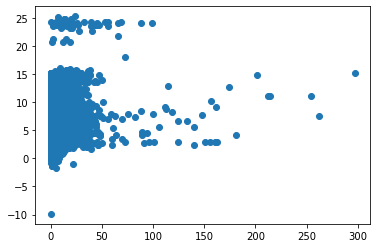

In [71]:
plt.scatter(lst1[50:], lst2[50:])

In [ ]:
torch.save(model, "/home/zluo/nn/GNN/trained.pt")